<a href="https://colab.research.google.com/github/JeanAlmeida1/Churn-Model/blob/main/Projeto_de_classifica%C3%A7%C3%A3o_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CHURN MODELLING 

Dataset: https://www.kaggle.com/shrutimechlearn/churn-modelling 

Comentário: Projeto utilizando uma base de dados de clientes de um banco, que visa criar um modelo de classificação de "churn", cujo objetivo é prever quais clientes deixarão de ser clientes no futuro.

##Importação das bibliotecas e da base de dados

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('Churn_Modelling.csv')

DICIONÁRIO:

* Tenure - Number of years for which the customer has been with the bank.
* NumOfProducts - Number of bank products the customer is utilising
* Balance - Bank balance of the customer 
* HasCrCard - Binary Flag for whether the customer holds a credit card with the bank or not
* IsActiveMember - Binary Flag for whether the customer is an active member with the bank or not
* Exited - Binary flag 1 if the customer closed account with bank and 0 if the customer is retained

##Análise descritiva 

### Inspeção inicial

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Observando os tipos de variáveis 

df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [5]:
# Deletando variáveis que não serão úteis

df = df.drop(columns=['RowNumber','CustomerId'])

In [6]:
#Verificando a quantidade de clientes e se a base de dados está completa 

print('Quantidade de clientes: ', df.shape[0])
print()
display('Dados nulos por coluna', df.isnull().sum())

Quantidade de clientes:  10000



'Dados nulos por coluna'

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
99%,850.000000,72.000000,10.000000,185967.985400,3.000000,1.00000,1.000000,198069.734500,1.000000


Observações:

* Apenas 20% dos clientes deixaram o banco no período observado. Portanto, nossa base de dados é desbalanceada. 
* Uma boa notícia é que não temos dados nulos. 
* Pelo "describe" podemos ver que variáveis como "Age" podem ter outliers.
* Pode-se perceber que mais de 25% da base de dados tem contas com saldo 0.
* As  variáveis não parecem apresentar valores discrepantes e irrealistas (como por exemplo idades acima de 100 anos). 

In [8]:
# Em quantidade de clientes, temos portanto: 

exited_dummy = pd.DataFrame(df['Exited'].value_counts())
exited_dummy = exited_dummy.reset_index()
exited_dummy = exited_dummy.rename({'index':'tipo_de_cliente', 'Exited':'qtd_clientes'}, axis=1)
exited_dummy['tipo_de_cliente'] = exited_dummy['tipo_de_cliente'].replace({0:'Cliente',1:'Ex-cliente'})

display(exited_dummy)

,tipo_de_cliente,qtd_clientes
0,Cliente,7963
1,Ex-cliente,2037


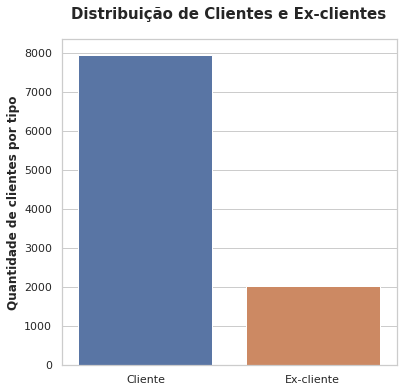

In [9]:
plt.figure(figsize=(6,6))
sns.set_theme(style='whitegrid')
sns.barplot(data=exited_dummy, x='tipo_de_cliente', y='qtd_clientes')
plt.xlabel('')
plt.ylabel('Quantidade de clientes por tipo', fontweight='bold')
plt.title('Distribuição de Clientes e Ex-clientes', fontsize=15, fontweight='bold', pad=20)
plt.show()

### Análise gráfica

<Figure size 432x288 with 0 Axes>

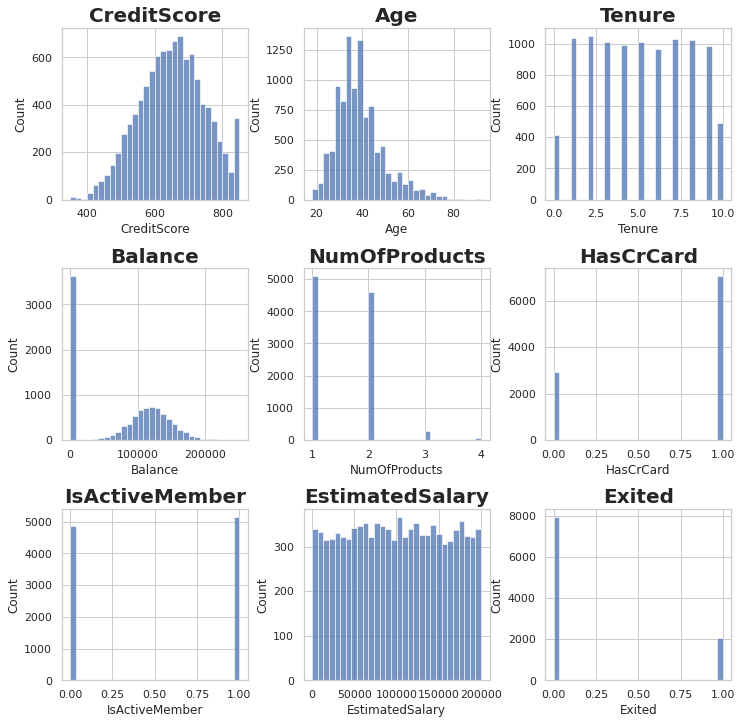

In [10]:
# Plotando o histograma das variáveis 

#1 - definindo o número de linhas e colunas do plot 
colnames_number = df.select_dtypes(include='number').columns
ncols = 3
nrows = int(np.ceil(len(colnames_number)/ncols*1.0))

#2 - Fazendo um for para percorrer todos os axis e plotar as figuras

fig = plt.figure()
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(12,12))   


counter = 0
for i in range(nrows):
  for j in range(ncols):
    ax = axes[i][j]
    
    if counter < len(colnames_number):
      sns.histplot(x = df.select_dtypes(include='number')[colnames_number[counter]], palette='hls', bins=30, ax=ax)
      ax.set_title(colnames_number[counter], fontsize=20, fontweight='bold')
    else:
      ax.set_axis_off()
    counter += 1 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

fig.show()


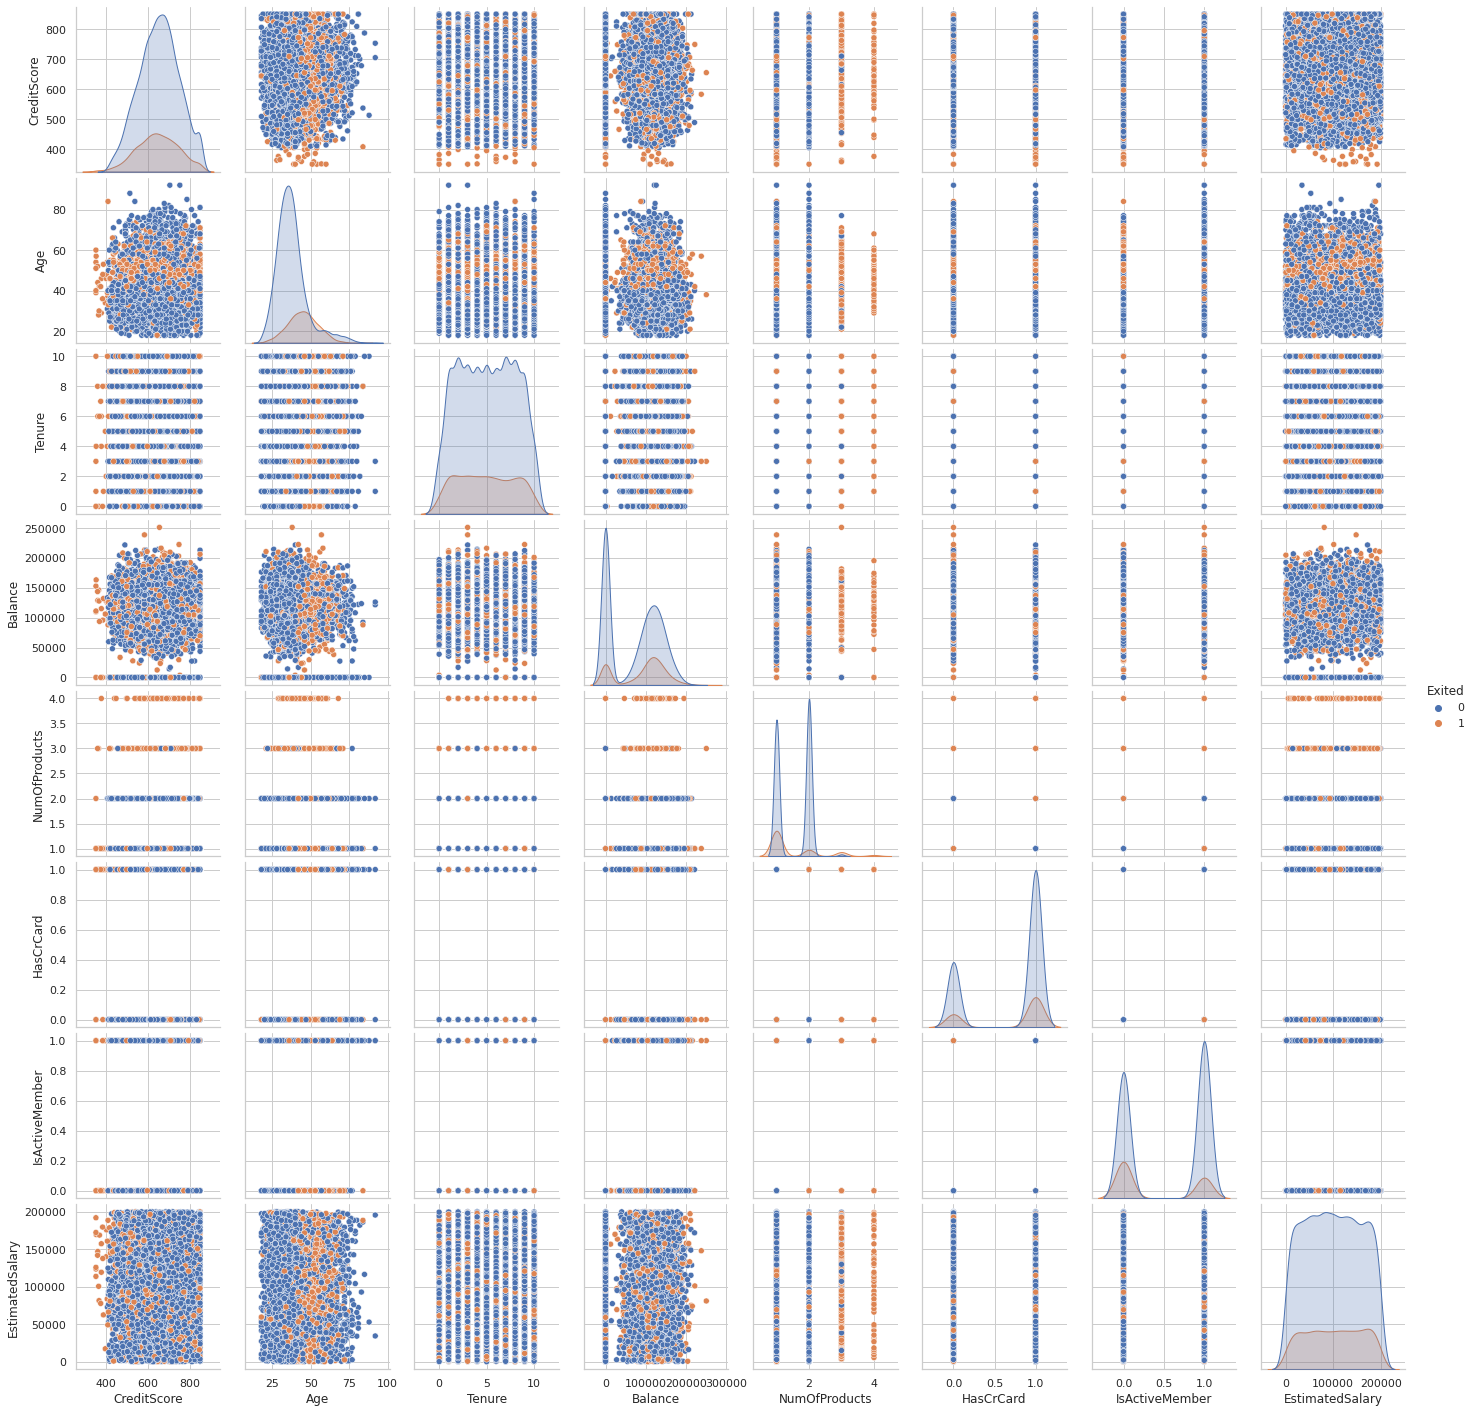

In [11]:
# Olhando correlação das variáveis numéricas 

sns.pairplot(df.select_dtypes(include='number'), hue='Exited')
plt.show()

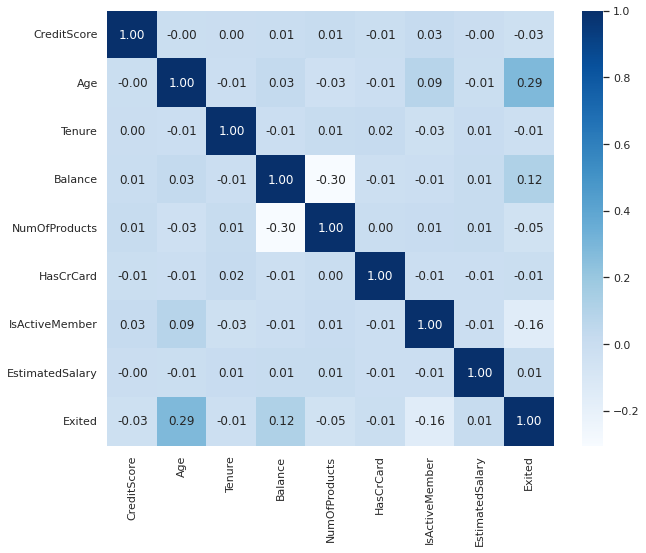

In [ ]:
# Matriz de correlação

p = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(p, annot=True, cmap=plt.cm.Blues, fmt='.2f')

Percebe-se que não existe nenhuma variável que correlaciona significativamente com "Exited". A maior correlação é um simples 0.29 de "Age". Pode-se inferir também que possivelmente não teremos problemas significativos com multicolinearidade das variáveis na etapa de modelagem.

### Separando as variáveis em numéricas, categóricas e objetos (strings)

In [13]:
# Temos por enquanto: 

df.dtypes

Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [14]:
# Criando um dataframe para mudar tipos de variáveis e preservar o dataframe original

df_dividido = df.copy()

df_dividido['Exited'] = df_dividido['Exited'].astype('category')
df_dividido['HasCrCard'] = df_dividido['HasCrCard'].astype('category')
df_dividido['IsActiveMember'] = df_dividido['IsActiveMember'].astype('category')

In [15]:
# Criando o dataframe de variáveis categóricas

dfCat = df_dividido.select_dtypes(include='category')
dfCat.head(3)

,HasCrCard,IsActiveMember,Exited
0,1,1,1
1,0,1,0
2,1,0,1


In [16]:
# Criando o dataframe de variáveis numéricas

dfNum = df_dividido.select_dtypes(include='number')
dfNum.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,619,42,2,0.00,1,101348.88
1,608,41,1,83807.86,1,112542.58
2,502,42,8,159660.80,3,113931.57


In [17]:
# Criando o dataframe de variáveis objeto 

dfObj = df_dividido.select_dtypes(include='object')
dfObj.head(3)

,Surname,Geography,Gender
0,Hargrave,France,Female
1,Hill,Spain,Female
2,Onio,France,Female


<Figure size 432x288 with 0 Axes>

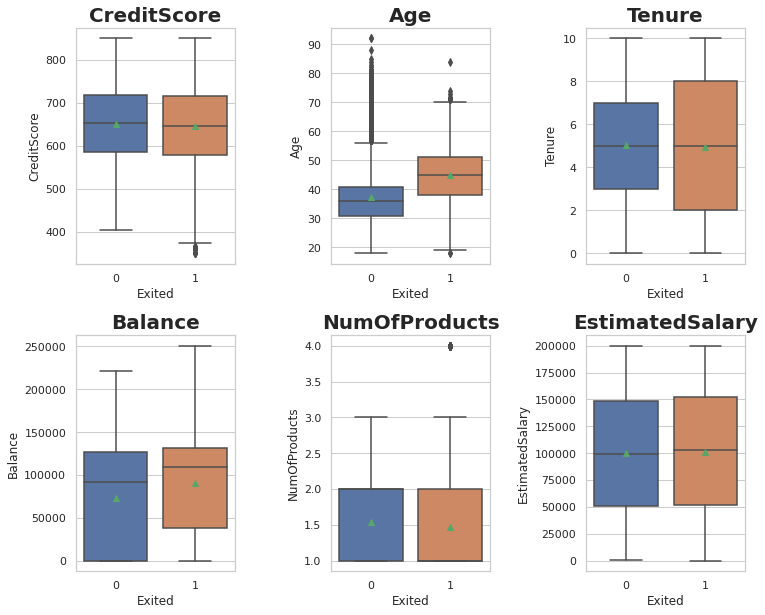

In [18]:
# Plotando o boxplot por extratificado por "Exited"

colnames_number = dfNum.columns
ncols = 3
nrows = int(np.ceil(len(colnames_number)/ncols*1.0))

fig = plt.figure()
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(12,10))   


counter = 0
for i in range(nrows):
  for j in range(ncols):
    ax = axes[i][j]
    
    if counter < len(colnames_number):
      sns.boxplot(y = dfNum[colnames_number[counter]], x = df['Exited'], palette='deep', showmeans=True, ax=ax)
      ax.set_title(colnames_number[counter], fontsize=20, fontweight='bold')
    else:
      ax.set_axis_off()
    counter += 1 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.3)

fig.show()


Podemos ver que temos um grande número de outliers em 'Age' para os que ainda são clientes, e um número significativo de outliers em CreditScore para os que deixaram de ser clientes. 

### O país do cliente é relevante? 

In [19]:
print('Quantidade de habitantes por país')
print()
print(df['Geography'].value_counts())

Quantidade de habitantes por país

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


In [20]:
# Dataframe df_exited_num com 'Exited' sendo variável numérica para vermos o resultado no agrupamento por país:

paises = df.groupby('Geography').mean()
paises

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,
France,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548
Germany,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734


Nossa variável target 'Exited' mostrou que os alemães deixaram de ser clientes em uma taxa duas vezes maior que a dos habitantes dos outros países.  A única variável numérica que parece diferir entre países é o Balance, onde os alemães possuem cerca do dobro de saldo que os habitantes dos outros países. 

<Figure size 432x288 with 0 Axes>

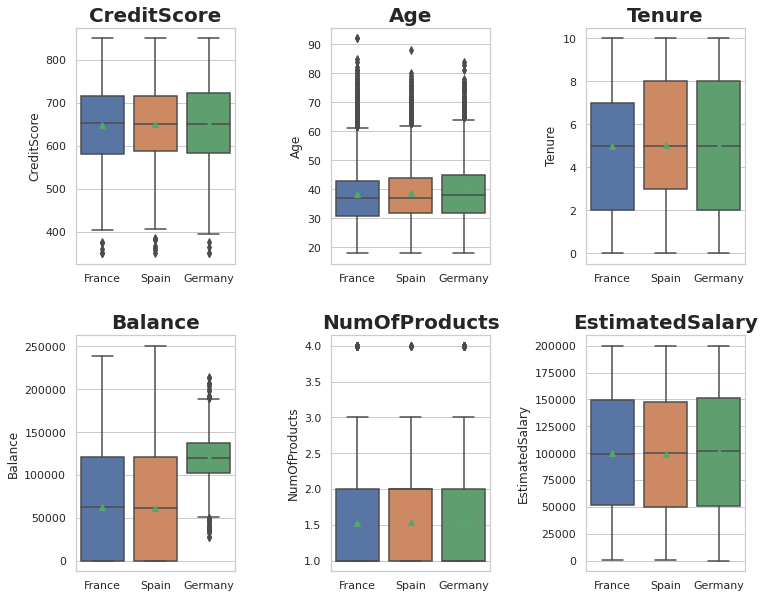

In [21]:
# Plotando o boxplot por extratificado por país de origem

colnames_number = dfNum.columns
ncols = 3
nrows = int(np.ceil(len(colnames_number)/ncols*1.0))

fig = plt.figure()
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(12,10))   


counter = 0
for i in range(nrows):
  for j in range(ncols):
    ax = axes[i][j]
    
    if counter < len(colnames_number):
      sns.boxplot(y = dfNum[colnames_number[counter]], x = df['Geography'], palette='deep', showmeans=True, ax=ax)
      ax.set_title(colnames_number[counter], fontsize=20, fontweight='bold')
      ax.set_xlabel('')
    else:
      ax.set_axis_off()
    counter += 1 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.3)

fig.show()


<Figure size 432x288 with 0 Axes>

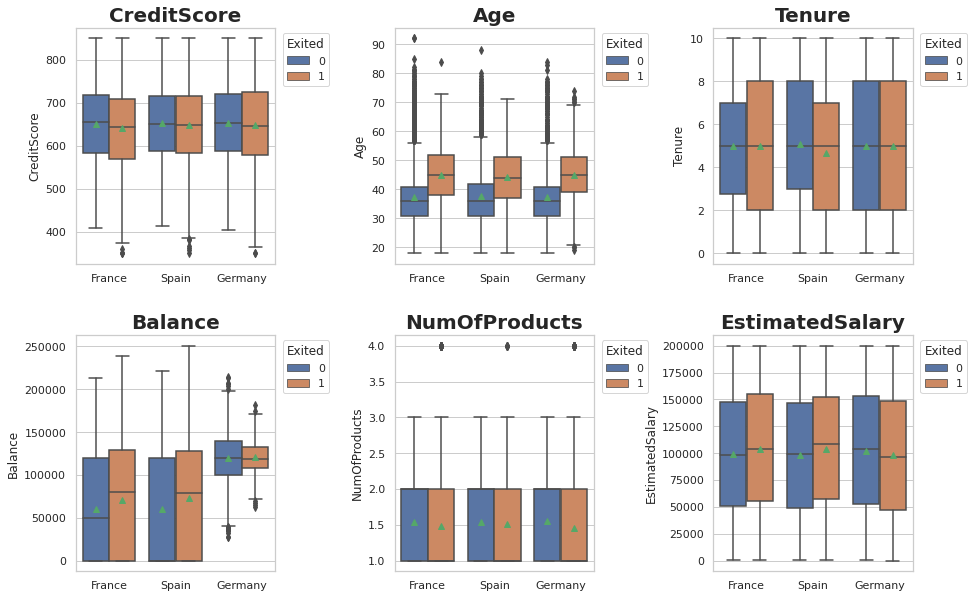

In [22]:
# Plotando o boxplot por extratificado por país de origem e "Exited"

colnames_number = dfNum.columns
ncols = 3
nrows = int(np.ceil(len(colnames_number)/ncols*1.0))

fig = plt.figure()
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(15,10))   


counter = 0
for i in range(nrows):
  for j in range(ncols):
    ax = axes[i][j]
    
    if counter < len(colnames_number):
      sns.boxplot(y = dfNum[colnames_number[counter]], x = df['Geography'], palette='deep', hue=df['Exited'], showmeans=True, ax=ax)
      ax.set_title(colnames_number[counter], fontsize=20, fontweight='bold')
      ax.set_xlabel('')
      ax.legend(title='Exited', loc='upper right',  bbox_to_anchor=[1.3, 1] )
    else:
      ax.set_axis_off()
    counter += 1 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.3)


fig.show()

Percebe-se claramente que o país é relevante para a análise de churn, principalmente considerando os clientes alemães. 

### Análise balance

In [23]:
# Dataframe separado entre clientes e ex-clientes
exit = df[df['Exited']==1]
client = df[df['Exited']==0]

In [24]:
exit['Balance'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.99])

count      2037.000000
mean      91108.539337
std       58360.794816
min           0.000000
1%            0.000000
5%            0.000000
25%       38340.020000
50%      109349.290000
75%      131433.330000
90%      152080.618000
99%      197355.288400
max      250898.090000
Name: Balance, dtype: float64

In [25]:
client['Balance'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.99])

count      7963.000000
mean      72745.296779
std       62848.040701
min           0.000000
1%            0.000000
5%            0.000000
25%           0.000000
50%       92072.680000
75%      126410.280000
90%      148730.298000
99%      183753.906200
max      221532.800000
Name: Balance, dtype: float64

Percebe-se um grande número de saldos zerados, tanto entre clientes quanto ex-clientes.

In [26]:
qtd_client = client.shape[0]
qtd_exclient = exit.shape[0]
qtd_client_zerado = client[client['Balance']==0].shape[0]
qtd_exclient_zerado = exit[exit['Balance']==0].shape[0]

print('Quantidade de clientes:    ', qtd_client)
print('Quantidade de ex-clientes: ', qtd_exclient)
print()
print('Clientes com a conta zerada:   {:.0f} pessoas ou {:.2f} % dos clientes'.format(((qtd_client_zerado / qtd_client)*qtd_client),((qtd_client_zerado / qtd_client)*100)))
print('Ex-clientes com a conta zerada: {:.0f} pessoas ou {:.2f} % dos ex-clientes'.format(((qtd_exclient_zerado / qtd_exclient)*qtd_exclient),((qtd_exclient_zerado / qtd_exclient)*100)))


Quantidade de clientes:     7963
Quantidade de ex-clientes:  2037

Clientes com a conta zerada:   3117 pessoas ou 39.14 % dos clientes
Ex-clientes com a conta zerada: 500 pessoas ou 24.55 % dos ex-clientes


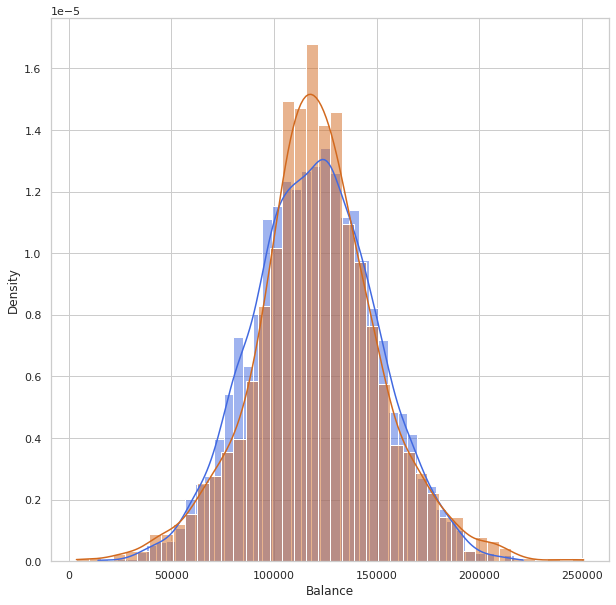

In [27]:
plt.figure(figsize=(10,10))
sns.histplot(data = client[client['Balance']>0], x='Balance', color='royalblue', stat='density', kde=True)
sns.histplot(data = exit[exit['Balance']>0], x='Balance', color='chocolate', stat='density', kde=True)


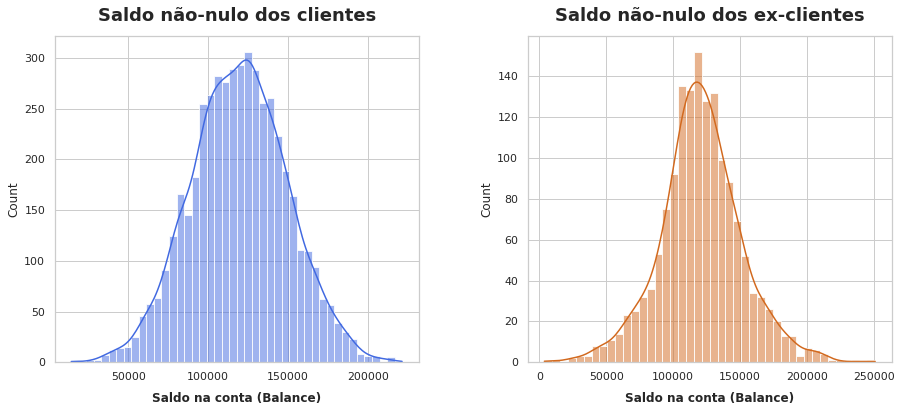

In [28]:
# Observando a distribuição dos saldos acima de zero para clientes e ex-clientes

plt.subplots(figsize=(15,6))

ax1 = plt.subplot(1, 2, 1)
sns.histplot(data = client[client['Balance']>0], x='Balance', color='royalblue', stat='count', kde=True)
ax1.set_title('Saldo não-nulo dos clientes', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel('Saldo na conta (Balance)', labelpad=10, fontweight='bold')

ax2 = plt.subplot(1, 2, 2)
sns.histplot(data = exit[exit['Balance']>0], x='Balance', color='chocolate', stat='count', kde=True)
ax2.set_title('Saldo não-nulo dos ex-clientes', fontsize=18, fontweight='bold', pad=15)
ax2.set_xlabel('Saldo na conta (Balance)', labelpad=10, fontweight='bold')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

plt.show()

A distribuição dos saldos dos clientes aparentam ser normalmente distribuídas para saldos acima de zero, ainda que os ex-clientes apresentam uma distribuição mais leptocúrtica que a dos clientes. 

## Pré-processamento das variáveis 

Passos: 
* Observar outliers anteriormente identificados: Age e CreditScore
* Separar as idades  em grupos
* Criar variáveis categóricas para Geography
* Transformar Gender em variável categórica
* Criar variável categórica de 'Balance zerado'

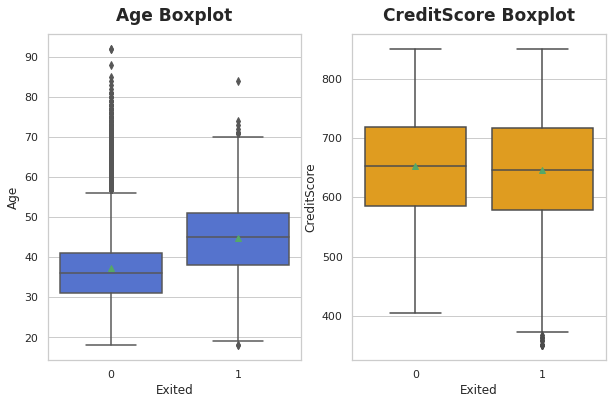

In [29]:
#Observando outliers de Age e CreditScore

fig, ax = plt.subplots(figsize=(10,6))

ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df, y='Age', x='Exited' ,color='royalblue', showmeans=True)
ax1.set_title('Age Boxplot', fontsize=17, fontweight='bold', pad=13)

ax2 = plt.subplot(1,2,2)
sns.boxplot(data=df, y='CreditScore', x='Exited', color='orange', showmeans=True)
ax2.set_title('CreditScore Boxplot', fontsize=17, fontweight='bold', pad=13)

plt.show()


* No CreditScore o comportamento dos clientes e ex-clientes é parecido, com somente os ex-clientes tendo outliers de scores muito baixos, o que é esperado.

* Já em Age, temos uma diferença significante entre os clientes e ex-clientes. Os ex-clientes possuem no geral idade bem maior, onde o primeiro quartil (25%) dos clientes é de cerca de 31 anos, enquanto para o ex-clientes esse número é de quase 40 anos. Média de idade de clientes é de cerca de 35; para os ex-clientes, 45. No terceiro quartil conseguimos perceber que 1/4 dos clientes tem mais de 41 anos, enquanto 1/4 dos ex-clientes tem mais de 50 anos.


### Discretização da variável Age (transformando a variável discreta em grupos categóricos de idade)

In [30]:
df['Age'].describe(percentiles=[0.01,0.05, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99])

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
1%          21.000000
5%          25.000000
25%         32.000000
50%         37.000000
75%         44.000000
80%         46.000000
90%         53.000000
95%         60.000000
99%         72.000000
max         92.000000
Name: Age, dtype: float64

Como a menor idade é 18 anos e o percentil 99% já me dá um valor de 72 anos, dividiremos as idades nos seguintes grupos: 

* 18 - 30
* 31 - 40
* 41 - 50
* 51 - 60
* 61 - 70
* 71 - 99

In [31]:
#As bins da função funcionam da forma: [17, 30, 40] = grupo 1 (>17 e <= 30), grupo 2 (>30 e <=40)

age_groups = pd.cut(df['Age'], bins=[17, 30, 40, 50, 60, 70, np.inf], labels=['18-30', '31-40', '41-50', '51-60', '61-70', '70-99'])
age_groups.value_counts()

31-40    4451
41-50    2320
18-30    1968
51-60     797
61-70     331
70-99     133
Name: Age, dtype: int64

In [32]:
df_age_groups = pd.get_dummies(age_groups, prefix='Age', prefix_sep=':')
df_age_groups.shape

(10000, 6)

In [33]:
# Fazendo um merge por index, para adicionar as novas colunas no dataframe
df_age_groups['index'] = df.index
df_age_groups.head(3)

,Age:18-30,Age:31-40,Age:41-50,Age:51-60,Age:61-70,Age:70-99,index
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,1
2,0,0,1,0,0,0,2


In [34]:
# Replicando o df com a adição de uma coluna index
df_index = df.copy()
df_index = df_index.reset_index()
df_index.head(3)

,index,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [36]:
df.shape, df_age_groups.shape, df_index.shape

((10000, 12), (10000, 7), (10000, 13))

In [35]:
dfnew = pd.merge(df_index, df_age_groups, on='index')
print('shape dfnew:', dfnew.shape)
dfnew.head(3)

shape dfnew: (10000, 19)


,index,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age:18-30,Age:31-40,Age:41-50,Age:51-60,Age:61-70,Age:70-99
0,0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,0
1,1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0,0,0
2,2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,0


In [ ]:
dfnew.dtypes

index                int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
Age:18-30            uint8
Age:31-40            uint8
Age:41-50            uint8
Age:51-60            uint8
Age:61-70            uint8
Age:70-99            uint8
dtype: object

Transformações necessárias em dfnew:

* Criar dummy para Geography, principalmente Alemanha
* Transformar Gender em número
* Remover posteriormente variáveis que não serão utilizadas e que já foram transformadas, como por exemplo Age e Geography.


### Transformação de Gender 

In [37]:
#Transformando Gender em dummy, com Female = 1

dfnew['Gender'] = dfnew['Gender'].replace({'Male':0,'Female':1})
dfnew['Gender'].value_counts()

0    5457
1    4543
Name: Gender, dtype: int64

### Transformação de Geography

In [38]:
df_geography = pd.get_dummies(dfnew['Geography'], drop_first=True)
df_geography = df_geography.reset_index()
df_geography.head(3)

,index,Germany,Spain
0,0,0,0
1,1,0,1
2,2,0,0


In [39]:
df_final = dfnew.merge(df_geography, on='index')
df_final.head()

,index,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,EstimatedSalary,Exited,Age:18-30,Age:31-40,Age:41-50,Age:51-60,Age:61-70,Age:70-99,Germany,Spain
0,0,Hargrave,619,France,1,42,2,0.00,1,1,...,101348.88,1,0,0,1,0,0,0,0,0
1,1,Hill,608,Spain,1,41,1,83807.86,1,0,...,112542.58,0,0,0,1,0,0,0,0,1
2,2,Onio,502,France,1,42,8,159660.80,3,1,...,113931.57,1,0,0,1,0,0,0,0,0
3,3,Boni,699,France,1,39,1,0.00,2,0,...,93826.63,0,0,1,0,0,0,0,0,0
4,4,Mitchell,850,Spain,1,43,2,125510.82,1,1,...,79084.10,0,0,0,1,0,0,0,0,1


In [40]:
df_final.dtypes

index                int64
Surname             object
CreditScore          int64
Geography           object
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
Age:18-30            uint8
Age:31-40            uint8
Age:41-50            uint8
Age:51-60            uint8
Age:61-70            uint8
Age:70-99            uint8
Germany              uint8
Spain                uint8
dtype: object

Por último, vamos excluir variáveis que não serão utilizadas na modelagem: index, Surname, Geography e Age.

In [41]:
df_final = df_final.drop(columns=['index','Surname','Geography','Age'])

In [42]:
df_final.head()

,CreditScore,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age:18-30,Age:31-40,Age:41-50,Age:51-60,Age:61-70,Age:70-99,Germany,Spain
0,619,1,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,0,0,0
1,608,1,1,83807.86,1,0,1,112542.58,0,0,0,1,0,0,0,0,1
2,502,1,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,0,0,0
3,699,1,1,0.00,2,0,0,93826.63,0,0,1,0,0,0,0,0,0
4,850,1,2,125510.82,1,1,1,79084.10,0,0,0,1,0,0,0,0,1


Nosso df_final tem 17 variáveis.

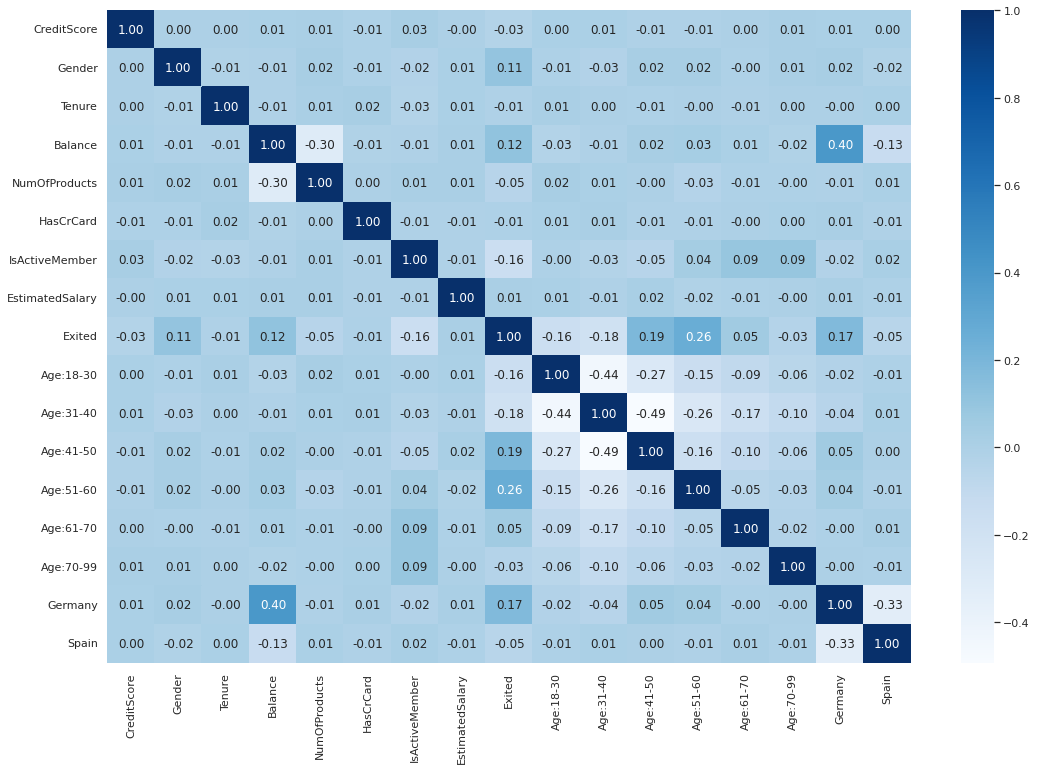

In [43]:
plt.figure(figsize=(18,12))
p_final = df_final.corr()
sns.heatmap(p_final, annot=True, cmap=plt.cm.Blues, fmt='.2f')

## Modelagem

### Passo a passo

Próximos passos: 

* Dividir os dados em dataset de treino e teste 
* Normalização dos dados
* Escolha do método de escolha das variáveis (SelectKBest, Boruta, análise descritiva, etc.)
* Escolha das variáveis a serem testadas 
* Escolha dos modelos a serem testados 
* Escolha das métricas a serem avaliadas
* Modelagem e escolha do melhor modelo 


### Normalizando e separando dados de treino e teste

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [45]:
# selecionando colunas com exceção de uma : df_final.columns[(df_final.columns != 'Exited')]

X = df_final[df_final.columns[(df_final.columns != 'Exited')]]
y = df_final['Exited']

In [46]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) 

In [47]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8000, 16), (2000, 16), (8000,), (2000,))

In [48]:
# Normalizando os dados de treino 

scaler = StandardScaler()
normalized_X_train = pd.DataFrame(scaler.fit_transform(Xtrain), columns = Xtrain.columns)

In [49]:
#normalizando os dados de teste

normalized_X_test = pd.DataFrame(scaler.transform(Xtest), columns = Xtest.columns)

### Escolhendo métricas

É muito importante escolher as métricas certas para avaliar os modelos. Por exemplo, uma métrica muito utilizada é a "accuracy":

**Accuracy** = número de previsões corretas / número total de previsões. 

Acontece que a acurácia não é uma boa métrica para uma base de dados desbalanceada igual a nossa, onde somente 20% da variável target tem valor 1. Se prevêssemos que todas as observações continuariam como clientes, ou seja, prever todos os valores como 0, nosso modelo não serviria para nada, mas apresentaria uma acurácia de 80%! 

Portanto é necessário encontrar métricas que realmente avaliem bem cada situação. Uma das maneiras de fazer isso é descobrir se você quer penalizar mais os Falsos Negativos do que os Falsos Positivos. No caso de um modelo de churn, um erro Falso Positivo quer dizer que o modelo previu que o cliente iria se tornar ex-cliente (iria ser churn), mas acabou não deixando o banco. Não é a melhor das situações, mas realmente é melhor que um Falso Negativo, que acontece quando o modelo prevê que o cliente não vai deixar de ser cliente e ele acaba saindo (sendo churn). 

Dessa forma, métricas que punam mais os Falsos Negativos parecem fazer mais sentido para o nosso problema de negócio. E que métricas podemos usar? 

**Recall** = número de predições positivas corretas / número total de positivos nos dados de teste

Utilizando o recall, podemos focar no erro mais importante para o nosso problema de negócio e não caímos no problema que podemos ter com dados desbalanceados. 

Exemplo da importância das métricas: 

Usarei dois modelos aqui, uma "decision tree" com hiperparâmetros defaut e um "modelo" onde predirei todas as observações como não-churn (valor 0). Calcularei as métricas "accuracy" e "recall" para cada um deles. 

### Modelo defaut com todas as features disponíveis 

In [50]:
# Utilizando decision tree sem otimização de hiperparâmetros para prever o churn

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [51]:
# Treinando o modelo 
model = DecisionTreeClassifier().fit(normalized_X_train, ytrain)

# Realizando previsões
yTree = model.predict(normalized_X_test)

In [52]:
# Obtendo métricas

Recall_Tree = recall_score(ytest, yTree)
Acc_Tree = accuracy_score(ytest, yTree)
print('Recall:', Recall_Tree)
print('Accuracy:', Acc_Tree)

Recall: 0.5241730279898219
Accuracy: 0.7845


Agora vou simplesmente prever todas as observações como não-churn, e calcular as mesmas métricas. 

In [53]:
#Prevendo as 2000 observações de teste como não-churn (array com 2 mil valores zero)

yPred_Zero = np.full(2000,0)
yPred_Zero

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
Recall_Pred_Zero = recall_score(ytest, yPred_Zero)
Acc_Pred_Zero = accuracy_score(ytest, yPred_Zero)
print('Recall:', Recall_Pred_Zero)
print('Accuracy:', Acc_Pred_Zero)

Recall: 0.0
Accuracy: 0.8035


O modelo que previu todos os valores como zero é completamente incapaz de detectar um cliente churn, mas apresentou uma accuracy de 80%, mais que a da nossa decision tree! Mas também podemos perceber que o Recall do nosso modelo zero é de 0, ou seja, não conseguiu prever certo nenhuma observação como 1, enquanto a nossa árvore de previsão obteve um recall de 52%. Dessa forma fica bem claro que o Recall é uma métrica muito mais informativa sobre qual o melhor modelo no nosso problema de negócio. 

### Criando uma baseline

Mas como podemos saber se certo valor de Recall é bom? Um jeito interessante é criar uma baseline de comparação, que é basicamente um modelo bem simples que tenta resolver o problema de negócio. Se os outros modelos não conseguirem superar a métrica desse modelo base, quer dizer que a qualidade desses não é o suficiente.  

Por exemplo, vamos criar um modelo que prevê o churn a partir do saldo na conta do cliente (variável Balance). Será utilizada uma árvore de decisão para ajustar esse modelo de uma só feature.

In [55]:
# Criando baseline: prevendo churn a partir do saldo na conta 

Xbaseline = np.array(df_final['Balance']).reshape(-1,1)
ybaseline = df_final['Exited']

Xtrainbase, Xtestbase, ytrainbase, ytestbase = train_test_split(Xbaseline, ybaseline, test_size=0.2, random_state=42) 

# normalizando as features
norm_Xtrainbase = pd.DataFrame(scaler.fit_transform(Xtrainbase))
norm_Xtestbase = pd.DataFrame(scaler.fit_transform(Xtestbase))

# treinando o modelo base: Decision Tree

model_baseline = DecisionTreeClassifier().fit(norm_Xtrainbase, ytrainbase)
yBaseline = model_baseline.predict(norm_Xtestbase) 

In [56]:
yBaseline

array([1, 0, 0, ..., 0, 0, 1])

In [57]:
# Avaliando o modelo base 

Recall_Baseline = recall_score(ytestbase, yBaseline)
Acc_Baseline = accuracy_score(ytestbase, yBaseline)
print('Recall:', Recall_Baseline)
print('Accuracy:', Acc_Baseline)

Recall: 0.17302798982188294
Accuracy: 0.7095


Nosso modelo de baseline com somente uma variável X teve um Recall de 17,3%. Podemos ver que ele teve um recall bem abaixo do nosso modelo com todas as variáveis X sendo utilizadas, que performou um recall de 52,4%. 

Mas e se selecionarmos somente algumas features X entre as disponíveis? É o que pretende-se fazer na sequência. 

### Selecionando melhor as variáveis 

Testamos um modelo com 1 feature e outro com todas as 17 features preparadas previamente. Será que existe algum meio termo que performa melhor? Para saber isso, utilizaremos o pacote Boruta, que visa encontrar as variáveis mais relevantes de uma base para a previsão de um fenômeno. 

In [58]:
pip install boruta

     |████████████████████████████████| 56 kB 3.7 MB/s 


In [59]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [60]:
#Preparando as variáveis 
df_sample = df_final.sample(frac=0.8, replace=True, random_state=42)

In [61]:
ytrain_boruta = df_sample['Exited'].values.ravel()
xtrain_cols = df_sample[df_sample.columns[(df_sample.columns != 'Exited')]]
xtrain_boruta = xtrain_cols.values

In [ ]:
# Definindo Boruta

rf = RandomForestRegressor(n_jobs=-1)
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 )
boruta_selec = boruta.fit(xtrain_boruta, ytrain_boruta)

In [63]:
# Separando as variáveis selecionadas
cols_selected = boruta.support_.tolist()
cols_selected_boruta = xtrain_cols.iloc[:, cols_selected].columns.to_list()

In [64]:
cols_selected_boruta

['CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary']

O Boruta é um método que nos retornou 4 variáveis: 'CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary'. Será que um modelo com essas variáveis retornarão um recall melhor no nosso modelo de árvore de decisão? 

### Modelo com variáveis escolhidas pelo Boruta

In [65]:
# Criando um train_test_split apenas com essas variáveis selecionadas 

Xb = df_final[['CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
yb = df_final['Exited']

Xtrain_b, Xtest_b, ytrain_b, ytest_b = train_test_split(Xb, yb, test_size=0.2, random_state=42) 

In [66]:
# Normalizando as variáveis 

normalized_Xtrain_b = pd.DataFrame(scaler.fit_transform(Xtrain_b), columns = Xtrain_b.columns)
normalized_Xtest_b = pd.DataFrame(scaler.transform(Xtest_b), columns = Xtest_b.columns)

In [67]:
# Treinando a árvore de decisão defaut 

model_b = DecisionTreeClassifier().fit(normalized_Xtrain_b, ytrain_b)
yPred_b = model_b.predict(normalized_Xtest_b)

In [68]:
# Calculando as métricas 

Recall_b = recall_score(ytest_b, yPred_b)
Acc_b = accuracy_score(ytest_b, yPred_b)
print('Recall:', Recall_b)
print('Accuracy:', Acc_b)

Recall: 0.3460559796437659
Accuracy: 0.718


As 4 features escolhidas pelo Boruta através de uma Decision Tree retornaram um recall de 35%, abaixo do recall de 52% que obtivemos com o modelo utilizando 17 features. 

### Visualizando as previsões

Na curva ROC, quanto mais a linha azul estiver à direita, melhor o nosso classificador. Quanto mais ela estiver junto à linha diagonal, pior o nosso modelo. Vamos visualizar agora a ROC das três árvores de decisão testados: 
* baseline: apenas uma feature (Balance)
* defaut: todas as 17 features disponíveis
* boruta: com 4 features escolhidas pelo método

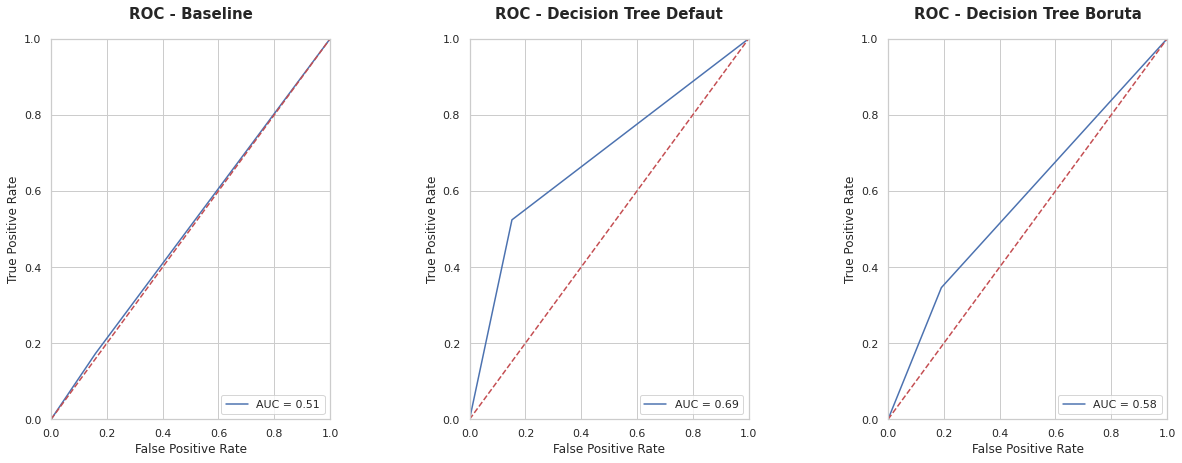

In [69]:
# Visualizando a Roc Curve do modelo base 

from sklearn.metrics import roc_curve 
from sklearn.metrics import auc 

fpr, tpr, threshold = roc_curve(ytestbase, yBaseline)
roc_auc = auc(fpr, tpr)

plt.subplots(figsize=(20,7))

ax1 = plt.subplot(1,3,1)
ax1.set_title('ROC - Baseline', fontsize=15, fontweight='bold', pad=20)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

# Visualizando a Roc Curve da decision tree com 16 variáveis X

fpr, tpr, threshold = roc_curve(ytest, yTree)
roc_auc = auc(fpr, tpr)

ax2 = plt.subplot(1,3,2)
ax2.set_title('ROC - Decision Tree Defaut', fontsize=15, fontweight='bold', pad=20)
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

# Visualizando a Roc Curve da decision tree com 16 variáveis X

fpr, tpr, threshold = roc_curve(ytest_b, yPred_b)
roc_auc = auc(fpr, tpr)

ax3 = plt.subplot(1,3,3)
ax3.set_title('ROC - Decision Tree Boruta', fontsize=15, fontweight='bold', pad=20)
ax3.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax3.legend(loc = 'lower right')
ax3.plot([0, 1], [0, 1],'r--')
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None) 

plt.show()

Pelo ROC podemos perceber o que o Recall retornou. Entre os três modelos testados, o melhor até agora foi a árvore de decisão utilizando todas as 17 features disponíveis. 

### Encontrando o melhor modelo

Já que o Boruta não conseguiu performar melhor que o modelo com todas as features nas nossas tentativas com decision trees, utilizaremos abaixo todas as variáveis X para encontrarmos o melhor modelo. Basicamente testaremos vários modelos com hiperparâmetros defaut, e o que performar melhor nas métricas escolhidas terá seus hiperparâmetros otimizados através do GridSearchCV. 

In [70]:
# Importando pacotes 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, log_loss, precision_recall_curve, auc, average_precision_score
import time 

In [71]:
# Definindo modelos a serem testados 

classification_models = {"LogisticRegression": LogisticRegression(),
                         "DecisionTree":DecisionTreeClassifier(),
                         "RandomForest": RandomForestClassifier(),
                         "XGBoost": XGBClassifier(),
                         "MLPClassifier": MLPClassifier(max_iter = 2000), # max_iter defaut = 200                     
} 



In [72]:
# Criando um looping para testar todos os modelos 

df_results = pd.DataFrame(columns=['model', 'run_time', 'recall', 'average_precision','log_loss'])

for key in classification_models:

    print('*',key)

    start_time = time.time()

    clas = classification_models[key]
    model = clas.fit(normalized_X_train, ytrain)
    y_pred = model.predict(normalized_X_test)

    scores = cross_val_score(model, 
                             normalized_X_train, 
                             ytrain,
                             scoring='recall', 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'recall': recall_score(ytest, y_pred),
           'average_precision': average_precision_score(ytest, y_pred),
           'log_loss': log_loss(ytest, y_pred)
    }

    df_results = df_results.append(row, ignore_index=True) 

* LogisticRegression
* DecisionTree
* RandomForest
* XGBoost
* MLPClassifier


In [73]:
df_results.sort_values(by='recall', ascending=False)

,model,run_time,recall,average_precision,log_loss
1,DecisionTree,0.01,0.519084,0.334620,7.356854
2,RandomForest,0.16,0.486005,0.458027,4.680032
3,XGBoost,0.18,0.452926,0.456508,4.628217
4,MLPClassifier,3.83,0.450382,0.418185,5.111771
0,LogisticRegression,0.0,0.330789,0.355472,5.612576


O modelo com o melhor recall foi a Decision Tree, mas esse modelo apresentou precisão média e log_loss ruins em relação aos outros. Portanto, apesar de ter o melhor recall, o modelo escolhido será a RandomForest.